# Airbnb data exploration

In this notebook we try to describe and explore the features of public datasets.

To look for more information about this public datasets look here: http://insideairbnb.com/get-the-data.html




In [64]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import matplotlib
from utils import download_datasets

In [79]:
#datasets
datasets_urls_boston = [
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/reviews.csv.gz'
]

datasets_urls_seattle = [
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/reviews.csv.gz'
]
datasets_urls_austin = [
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/reviews.csv.gz'
]

download_datasets(datasets_urls_boston, 'boston_')
download_datasets(datasets_urls_seattle, 'seattle_')
download_datasets(datasets_urls_austin, 'austin_')


datasets_cities = [
    'seattle',
    'boston',
    'austin'
]

datasets_cities = ['seattle', 'boston', 'austin']

File: boston_listings.csv.gz, in cache
File: boston_calendar.csv.gz, in cache
File: boston_reviews.csv.gz, in cache
File: seattle_listings.csv.gz, in cache
File: seattle_calendar.csv.gz, in cache
File: seattle_reviews.csv.gz, in cache
File: austin_listings.csv.gz, in cache
File: austin_calendar.csv.gz, in cache
File: austin_reviews.csv.gz, in cache


In [80]:
#Reading files


listings = []
calendar = []
reviews = []

for city in datasets_cities:
    listings += [pd.read_csv(city+'_listings.csv.gz')]
    calendar += [pd.read_csv(city+'_calendar.csv.gz', parse_dates=['date'])]
    reviews  += [pd.read_csv(city+'_reviews.csv.gz')]

listings = pd.concat(listings)
calendar = pd.concat(calendar)
reviews = pd.concat(reviews)



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
## Basics stats
print("Count of listings")
print(listings.count()[0])
print("Calendar has every listing?")
print(listings.count()[0] == calendar.groupby("listing_id").all().count()[0])


Count of listings
25970
Calendar has every listing?
True


In [82]:
#transform 't' or 'f' into True or False values.
calendar.available = calendar.available.apply(lambda x: x == "t")
#remove $ sign and parse the value as numeric.
calendar.price = calendar.price.apply(lambda x: float(str(x).replace("$","").replace(",","")))

calendar.dtypes

listing_id             int64
date          datetime64[ns]
available               bool
price                float64
dtype: object

In [83]:
null_percent_price = calendar.price.isnull().sum() / (calendar.price.shape[0])

print("Percent of null elements in the price column: ", null_percent_price)

Percent of null elements in the price column:  0.6196350900142947


In [84]:
#Computing scalers.
min_date = calendar.date.min()
max_date = calendar.date.max()

min_price = calendar.price.min()
max_price = calendar.price.max()

scaler_date = MinMaxScaler()
scaler_price = MinMaxScaler()

scaler_date.fit([[min_date.timestamp()], [max_date.timestamp()]])
scaler_price.fit([[min_price], [max_price]])


def slope_value(data):
    x = data.copy()
    x['date'] = x['date'].apply(lambda x: float(x.timestamp()))
    x = x.dropna()

    if x.shape[0] == 0:
        return np.nan

    X = x['date'].values.reshape(x['date'].shape[0], 1)
    y = x['price'].values.reshape(x['price'].shape[0], 1)

    X = scaler_date.transform(X)
    y = scaler_price.transform(y)

    lm = LinearRegression(n_jobs=-1)
    lm.fit(X, y)

    return lm.coef_[0][0]


def variation_metric(data):
    x = data.copy()
    x = x.dropna()
    x = x['price'].values
    if x.shape[0] == 0:
        return np.nan
    
    var_score = 0
    last_val = x[0]
    
    for val in x[1:]:
        if last_val != val:
            var_score += 1
        last_val = val
    
    return var_score
  
def minmax_metric(data):
    x = data.copy()
    x = x.dropna()
    if x.shape[0] == 0:
        return np.nan
    return x.price.min()/x.price.max()

def availability_metric(data):
    available_count = data[data.available == True]['available'].sum()
    return available_count/data.available.shape[0]

def std_metric(data):
    return data.price.std()
    
def mean_metric(data):
    return data.price.mean()

min_max = calendar.groupby('listing_id').apply(lambda x: minmax_metric(x))
slope = calendar.groupby('listing_id').apply(lambda x: slope_value(x))
variation = calendar.groupby('listing_id').apply(lambda x: variation_metric(x))
available = calendar.groupby('listing_id').apply(lambda x: availability_metric(x))
std = calendar.groupby('listing_id').apply(lambda x: std_metric(x))
mean = calendar.groupby('listing_id').apply(lambda x: mean_metric(x))

,min_max,slope,variation,available,std,mean
listing_id,,,,,,
2265,0.863636,0.032323,0.013736,0.298630,0.009631,0.021084
2318,0.796000,0.032185,0.019231,0.901370,0.021574,0.032007
3781,0.916667,0.032437,0.071429,0.246575,0.004667,0.013293
4291,1.000000,0.032433,0.002747,0.953425,0.000381,0.008299
5245,0.857143,0.032366,0.008242,0.400000,0.005626,0.013010
5456,0.635714,0.032549,0.162088,0.884932,0.024813,0.013526
5506,0.790000,0.032438,0.010989,0.841096,0.005448,0.014771
5682,0.842105,0.032408,0.024725,0.060274,0.002451,0.005659
5769,0.954545,0.032436,0.030220,0.178082,0.000790,0.004143


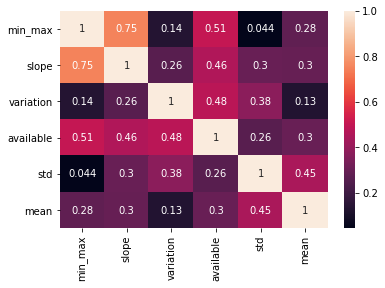

In [234]:
min_max.name = "min_max"
slope.name ="slope"
variation.name = "variation"
available.name = "available"
std.name = "std"
mean.name = "mean"

combined_metrics_original = pd.concat([min_max, slope, variation, available, std, mean], axis=1)
#combined_metrics = pd.DataFrame(slope)
scaler_combined = MinMaxScaler()
combined_metrics = combined_metrics_original.fillna(-1)
combined_metrics[combined_metrics.columns] = scaler_combined.fit_transform(combined_metrics[combined_metrics.columns])
corr_matrix = combined_metrics.corr()
sns.heatmap(corr_matrix, annot=True);
display(combined_metrics)

## Listings

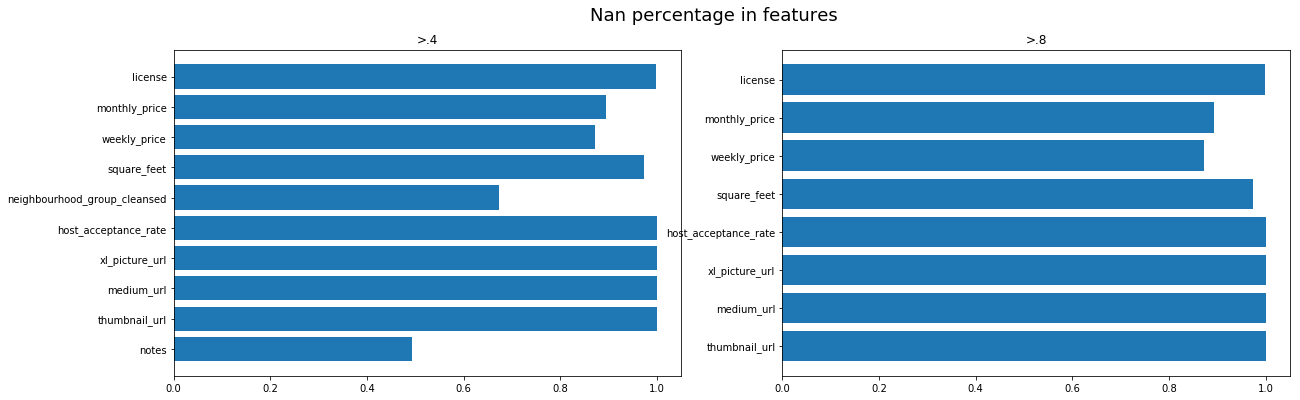

In [200]:
#Getting null % for each feature

total_size = listings.shape[0]

labels_ = [[],[]]
values_ = [[],[]]


for feature in listings:
    nulls_percentage = listings[feature].isna().sum()/total_size
    if nulls_percentage > .4:
        labels_[0] += [feature]
        values_[0] += [nulls_percentage]
    if nulls_percentage > .8:
        labels_[1] += [feature]
        values_[1] += [nulls_percentage]
    

plt.figure(1, figsize=(20, 6))
plt.suptitle('Nan percentage in features', fontsize=18)
plt.xticks(rotation='vertical')
plt.subplot(121)
plt.title('>.4')
plt.barh(labels_[0], values_[0])
plt.subplot(122)
plt.title('>.8')
plt.barh(labels_[1], values_[1])
plt.show();

In [201]:
[print(labels_[0][i], ":", values_[0][i]) for i in range(len(values_[0]))];
listings_dropna = listings.drop(labels_[0], axis=1)

notes : 0.49252984212552947
thumbnail_url : 1.0
medium_url : 1.0
xl_picture_url : 1.0
host_acceptance_rate : 1.0
neighbourhood_group_cleansed : 0.6729303041971506
square_feet : 0.9741624951867539
weekly_price : 0.8729303041971506
monthly_price : 0.8940315748941086
license : 0.9991143627262226


In [202]:
scaler = MinMaxScaler()
num_listings = listings_dropna.select_dtypes(include=np.number).dropna()
cols = list(set(num_listings.columns) - set(['id', 'scrape_id', 'host_id']))
num_listings[cols] = scaler.fit_transform(num_listings[cols])
num_listings.describe().T

,count,mean,std,min,25%,50%,75%,max
id,20523.0,1.500862e+07,7.877103e+06,2.265000e+03,8.173136e+06,1.669155e+07,2.160886e+07,2.769813e+07
scrape_id,20523.0,2.018082e+13,1.174566e+06,2.018081e+13,2.018081e+13,2.018082e+13,2.018082e+13,2.018082e+13
host_id,20523.0,4.550954e+07,5.075500e+07,2.000000e+01,6.991842e+06,2.426302e+07,6.885439e+07,2.082981e+08
host_listings_count,20523.0,3.853746e-02,1.549930e-01,0.000000e+00,7.530120e-04,1.506024e-03,3.765060e-03,1.000000e+00
host_total_listings_count,20523.0,3.853746e-02,1.549930e-01,0.000000e+00,7.530120e-04,1.506024e-03,3.765060e-03,1.000000e+00
latitude,20523.0,5.272298e-01,4.396773e-01,0.000000e+00,1.020921e-02,6.941332e-01,9.928735e-01,1.000000e+00
longitude,20523.0,4.274888e-01,3.783737e-01,0.000000e+00,2.013789e-03,4.796052e-01,4.810378e-01,1.000000e+00
accommodates,20523.0,1.096169e-01,9.744102e-02,0.000000e+00,3.703704e-02,7.407407e-02,1.481481e-01,1.000000e+00
bathrooms,20523.0,1.020102e-01,5.200162e-02,0.000000e+00,7.407407e-02,7.407407e-02,1.111111e-01,1.000000e+00
bedrooms,20523.0,9.013417e-02,6.476545e-02,0.000000e+00,5.882353e-02,5.882353e-02,1.176471e-01,1.000000e+00


In [203]:
combined_metrics.index.name = 'id'
combined_metrics

,min_max,slope,variation,available,std,mean
id,,,,,,
2265,0.863636,0.032323,0.013736,0.298630,0.009631,0.021084
2318,0.796000,0.032185,0.019231,0.901370,0.021574,0.032007
3781,0.916667,0.032437,0.071429,0.246575,0.004667,0.013293
4291,1.000000,0.032433,0.002747,0.953425,0.000381,0.008299
5245,0.857143,0.032366,0.008242,0.400000,0.005626,0.013010
5456,0.635714,0.032549,0.162088,0.884932,0.024813,0.013526
5506,0.790000,0.032438,0.010989,0.841096,0.005448,0.014771
5682,0.842105,0.032408,0.024725,0.060274,0.002451,0.005659
5769,0.954545,0.032436,0.030220,0.178082,0.000790,0.004143


In [204]:
num_listings = num_listings.set_index('id')
num_listings

,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
2318,20180816121209,2536,0.001506,0.001506,0.992853,0.002505,0.259259,0.185185,0.235294,0.111111,...,0.025568,1.0000,1.000,1.000,1.000,1.000,1.000,1.000,0.003322,0.007744
4291,20180816121209,35749,0.003765,0.003765,0.997218,0.002065,0.037037,0.074074,0.058824,0.027778,...,0.079545,0.8875,0.875,0.875,1.000,0.875,0.875,0.875,0.013289,0.046464
5682,20180816121209,8993,0.000753,0.000753,0.987930,0.001162,0.037037,0.074074,0.000000,0.027778,...,0.634943,0.9375,1.000,1.000,1.000,1.000,0.875,1.000,0.000000,0.225607
6606,20180816121209,14942,0.003012,0.003012,0.995308,0.001595,0.037037,0.074074,0.058824,0.027778,...,0.174716,0.9125,0.875,0.875,1.000,0.875,1.000,0.875,0.006645,0.057305
9419,20180816121209,30559,0.003765,0.003765,0.989441,0.001935,0.037037,0.222222,0.058824,0.027778,...,0.177557,0.9000,0.875,0.875,1.000,1.000,0.875,0.875,0.013289,0.066082
9460,20180816121209,30832,0.003012,0.003012,0.992694,0.001768,0.037037,0.074074,0.058824,0.027778,...,0.545455,0.9750,1.000,1.000,1.000,1.000,1.000,1.000,0.009967,0.181724
9531,20180816121209,31481,0.001506,0.001506,0.989711,0.000679,0.111111,0.074074,0.117647,0.138889,...,0.046875,1.0000,1.000,1.000,1.000,1.000,1.000,1.000,0.003322,0.021167
9534,20180816121209,31481,0.001506,0.001506,0.989759,0.000655,0.074074,0.074074,0.117647,0.055556,...,0.044034,1.0000,1.000,1.000,1.000,1.000,1.000,1.000,0.003322,0.020134
9596,20180816121209,14942,0.003012,0.003012,0.995346,0.001616,0.111111,0.074074,0.058824,0.166667,...,0.093750,0.8750,0.875,0.875,1.000,0.875,1.000,0.875,0.006645,0.039236


In [205]:
result = pd.merge(combined_metrics, num_listings, on='id')
result

,min_max,slope,variation,available,std,mean,scrape_id,host_id,host_listings_count,host_total_listings_count,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
2265,0.863636,0.032323,0.013736,0.298630,0.009631,0.021084,20180814184228,2466,0.002259,0.002259,...,0.029830,0.9000,0.875,1.000,0.875,1.000,0.750,0.875,0.006645,0.009293
2318,0.796000,0.032185,0.019231,0.901370,0.021574,0.032007,20180816121209,2536,0.001506,0.001506,...,0.025568,1.0000,1.000,1.000,1.000,1.000,1.000,1.000,0.003322,0.007744
3781,0.916667,0.032437,0.071429,0.246575,0.004667,0.013293,20180817025537,4804,0.003765,0.003765,...,0.018466,0.9875,1.000,1.000,1.000,1.000,1.000,1.000,0.003322,0.018585
4291,1.000000,0.032433,0.002747,0.953425,0.000381,0.008299,20180816121209,35749,0.003765,0.003765,...,0.079545,0.8875,0.875,0.875,1.000,0.875,0.875,0.875,0.013289,0.046464
5245,0.857143,0.032366,0.008242,0.400000,0.005626,0.013010,20180814184228,2466,0.002259,0.002259,...,0.011364,0.8875,1.000,0.750,1.000,0.875,1.000,0.875,0.006645,0.003614
5456,0.635714,0.032549,0.162088,0.884932,0.024813,0.013526,20180814184228,8028,0.000753,0.000753,...,0.627841,0.9500,1.000,1.000,1.000,1.000,0.875,1.000,0.000000,0.198761
5506,0.790000,0.032438,0.010989,0.841096,0.005448,0.014771,20180817025537,8229,0.004518,0.004518,...,0.095170,0.9375,1.000,1.000,1.000,1.000,0.875,1.000,0.016611,0.029943
5682,0.842105,0.032408,0.024725,0.060274,0.002451,0.005659,20180816121209,8993,0.000753,0.000753,...,0.634943,0.9375,1.000,1.000,1.000,1.000,0.875,1.000,0.000000,0.225607
5769,0.954545,0.032436,0.030220,0.178082,0.000790,0.004143,20180814184228,8186,0.001506,0.001506,...,0.333807,0.9750,1.000,1.000,1.000,1.000,0.875,1.000,0.000000,0.119257


In [206]:
corr_matrix = result.corr()
corr_matrix.style.background_gradient()

,min_max,slope,variation,available,std,mean,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
min_max,1,0.827895,0.102625,0.446638,0.00753008,0.287788,0.10695,0.00381705,0.00128948,0.00128948,0.134099,-0.0614714,0.00033116,0.0108411,-0.00895163,0.0132097,0.0345414,0.0562496,0.00180597,0.381375,0.449407,0.500191,0.446638,0.162892,0.0352188,0.0362753,0.0918504,0.0394673,0.014614,0.0196991,0.0358549,0.0288268,0.230192
slope,0.827895,1,0.279966,0.475863,0.229249,0.348049,0.0552931,0.012429,0.0994721,0.0994721,0.0673325,-0.0282124,0.0949576,0.0541026,0.0453016,0.0859753,0.110812,0.0244543,0.00321879,0.421568,0.484148,0.528567,0.475863,0.182792,0.0145181,0.0169036,0.0983569,0.0190275,-0.00338682,0.037418,0.0102581,0.11474,0.258378
variation,0.102625,0.279966,1,0.496565,0.374056,0.198714,-0.0294148,0.05265,0.313503,0.313503,-0.016354,-0.0214927,0.177558,0.0629715,0.0879851,0.148949,0.171128,-0.0323919,0.00176083,0.2986,0.355951,0.389346,0.496565,0.121561,-0.0684497,-0.0628335,0.0429063,-0.0754318,-0.0725774,0.0249996,-0.0779404,0.302178,0.15118
available,0.446638,0.475863,0.496565,1,0.257093,0.31317,-0.0451271,-0.0321189,0.0968933,0.0968933,-0.0455275,0.00507756,0.14746,0.113502,0.105103,0.146397,0.15012,0.0738603,0.00128934,0.491996,0.576717,0.635032,1,0.135692,-0.0299378,-0.0351478,0.0396916,-0.0177912,-0.0491437,-0.00253267,-0.0502964,0.0713935,0.0329081
std,0.00753008,0.229249,0.374056,0.257093,1,0.574595,-0.111913,0.0443201,0.170925,0.170925,-0.148721,0.0796713,0.44858,0.330788,0.366184,0.433719,0.366268,0.0217928,0.00286019,0.238143,0.237401,0.235632,0.257093,0.0136734,-0.00984982,-0.0232333,0.0411599,-0.0240787,-0.0393784,0.0399181,-0.0552833,0.164093,0.0253399
mean,0.287788,0.348049,0.198714,0.31317,0.574595,1,-0.0665742,-0.00265214,0.157956,0.157956,-0.0980103,0.0653863,0.551506,0.501295,0.518129,0.513012,0.407421,0.0465448,0.000212442,0.315193,0.310759,0.307507,0.31317,-0.0413276,0.0340857,-0.000730596,0.0673891,-0.00820505,-0.0275692,0.0579201,-0.0472958,0.163924,-0.054466
scrape_id,0.10695,0.0552931,-0.0294148,-0.0451271,-0.111913,-0.0665742,1,-0.00178126,0.175224,0.175224,0.84998,0.180068,-0.188198,-0.155772,-0.173138,-0.155729,-0.160507,-0.011797,-0.00771203,-0.231921,-0.146455,-0.0943797,-0.0451271,0.0822612,-0.147656,-0.0899755,-0.0592583,-0.0766746,-0.0964227,-0.0639845,-0.12646,0.193671,0.16029
host_id,0.00381705,0.012429,0.05265,-0.0321189,0.0443201,-0.00265214,-0.00178126,1,-0.0771399,-0.0771399,-0.0205111,0.0353469,0.031612,0.0150643,0.00690056,0.0383309,0.0506631,-0.0491231,-0.00626623,0.00222066,0.0135886,0.0166977,-0.0321189,-0.178488,-0.037986,-0.03155,-0.0317658,-0.039152,-0.0447766,-0.0120862,-0.0207614,-0.0946655,0.152138
host_listings_count,0.00128948,0.0994721,0.313503,0.0968933,0.170925,0.157956,0.175224,-0.0771399,1,1,0.0955012,0.131371,0.00690655,0.0195817,-0.000334304,-0.00608876,-0.0179255,-0.00606519,-0.00175107,0.16413,0.180731,0.179543,0.0968933,-0.10151,-0.158141,-0.155478,-0.0155766,-0.201643,-0.192123,-0.0298121,-0.167349,0.82367,-0.118251
host_total_listings_count,0.00128948,0.0994721,0.313503,0.0968933,0.170925,0.157956,0.175224,-0.0771399,1,1,0.0955012,0.131371,0.00690655,0.0195817,-0.000334304,-0.00608876,-0.0179255,-0.00606519,-0.00175107,0.16413,0.180731,0.179543,0.0968933,-0.10151,-0.158141,-0.155478,-0.0155766,-0.201643,-0.192123,-0.0298121,-0.167349,0.82367,-0.118251


In [247]:
from sklearn.ensemble import RandomForestRegressor

targets_ = ["min_max", "slope", "variation", "available", "std", "mean"]
target = "reviews_per_month"

if target in targets_:
    targets_.remove(target)

result = result.dropna()
y = result[target]
X = result.drop(['scrape_id', 'host_id'] + targets_, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

regressor = RandomForestRegressor(n_jobs=-1)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [248]:
from sklearn.metrics import mean_absolute_error, explained_variance_score
y_pred = regressor.predict(X_test)

mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
ev = explained_variance_score(y_pred=y_pred, y_true=y_test)
print("MAE: {0}".format(mae))
print("EV: {0}".format(ev))

MAE: 0.00013836139281697406
EV: 0.9995951377039616


In [249]:
a = pd.Series(y_test.values, name='test')
b = pd.Series(y_pred, name='pred')
results = pd.concat([a, b], axis=1)

max_ = combined_metrics_original[target].max()
min_ = combined_metrics_original[target].min()

scaler = MinMaxScaler()
scaler.fit([[max_,max_], [min_, min_]])
std_results = pd.DataFrame(scaler.inverse_transform(results.values), columns=['test', 'pred'])

KeyError: 'reviews_per_month'

In [ ]:
if target not in targets_:
    

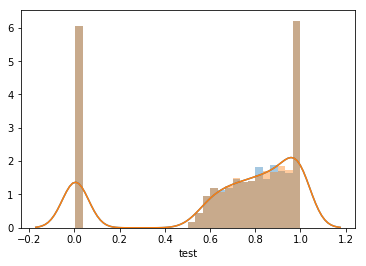

In [250]:
temp1 = std_results['pred']
sns.distplot(temp1);
temp2 = std_results['test']
sns.distplot(temp2);

In [101]:
calendar.columns = ['id', 'date', 'available', 'price']
calendar_listings = pd.merge(calendar, num_listings, on='id')
calendar_listings = calendar_listings.drop(['scrape_id', 'host_id', 'id'], axis=1)